**------------------------------Alles in einem Block nur in Abhängigkeit der 4 Parameter---------------------------------** 


In [1]:
#Alles was konstant ist
using Flux
using Zygote
using PyPlot
using LinearAlgebra

using Random

using JLD2

using BenchmarkTools
using Dates

using LsqFit

In [2]:
function H(X) #X matrix mit einträgen +-1
    
    n1=length(X[:,1]) # n x m matrix (n zeilen)
    m1=length(X[1,:])
    
    nullen_h= zeros(n1,1) #h, Horizontal anfügen
    nullen_v= zeros(1,m1+2)
    
    X0 = vcat(vcat(nullen_v,hcat(hcat(nullen_h,X),nullen_h)),nullen_v) #Umrande die Matrix mt 0en
    
    E=0
    n=length(X0[:,1]) # n x m matrix (n zeilen)
    m=length(X0[1,:])
    
    for i in 1:n
        for j in 1:m #summe über nächste nachbarn, Rand macht automatisch keinen beitrag, weil Rand = 0
            
            if 1<i<n && 1<j<m
                E = E+X0[i,j]*(X0[i-1,j]+X0[i+1,j]+X0[i,j-1]+X0[i,j+1])
            end
        end
    end
        return -0.5*E #0.5 weil paare doppelt gezählt
end

H (generic function with 1 method)

**Daten Laden und Formatieren**

**Die Daten (cofigurationen X_i) muss man sich selbst generieren, da diese zu groß für Github sind** (mit 'Wolff algorithm sampling.ipynb' )

**Die Daten für Delta_avg sind im repositoy vorhanden**

In [6]:
#Systemgröße
ns = 10

#Speichern aller Daten in diesen Arrays (Format siehe Unten)
x_ges = []
y_ges = []


#Laden der Daten----------------------------------------------------------------------

Datei = load_object("W_Ketten T_Anzahl=20 Länge=10000 n_m=$(ns^2) T1_T2=0.01_5.0.jdl2")
    
T_range = Datei[1]
T_range = round.(T_range,digits=3) # runden, damit plots schöner
Wolfketten = Datei[2]
    
T_n_range = collect(1:length(T_range)) # Indexe T_n zu den verschiedenen Temperaturen


#Formatierng aller Daten-----------------------------------------------------------------
for T_n in T_n_range
        
        
N_ges = length(Wolfketten[T_n])

#Umformatierung der Matrix Konfigurationen in einen Vektor
x_ges_T_n = []
for i in 1:N_ges
    push!(x_ges_T_n, reshape(Wolfketten[T_n][i],(:,1)))
end

#Berechnung der wahren Werte für -H(X)/T
y_ges_T_n = []
for i in 1:N_ges
    push!(y_ges_T_n, -H(Wolfketten[T_n][i]) / (T_range[T_n]) )
end      
#    -----------------------------------------------------------------------------------     
    push!(x_ges, x_ges_T_n) 
    push!(y_ges, y_ges_T_n) 
    
#-----------Mischen der Daten: ------------------------------------------------------------------------
    
        #Bei Temperatur ca. 1.0 verändern sich die zustände langsam,
        #bzw stecken in der nähe einer konfiguration fest, man würde ohne mischen dort dann einen unsinnigen Peak haben.
        # Peakfür die differenz der vorhersage zu dne wahen werten

Random.seed!(1111)
   x_ges[T_n] = shuffle(x_ges[T_n])
Random.seed!(1111) #Damit y werte genau so gemixt werden und man die 1:1 beziehung erhält
   y_ges[T_n] =  shuffle(y_ges[T_n])
 
end #t_n
    
    #Abspeichern Aller Daten im Format:
        #
        # x_ges[index der Temperatur T_n][1 von 10000 Konfigurationen als Vektor] 
        #
        # y_ges[index der Temperatur T_n][1 von 10000 -(Energien/Temp.)]


LoadError: UndefVarError: H not defined


**Funktion**          


**für Qualtiät der Vorhersage: 4 Parameter**

In [5]:
# Dokumentation für die Funktion Difference

# N_tr + N_te <= N_ges (Sonst werden trainingsdaten als testdaten verwendet oder Fehlermeldung wenn N_tr > N_ges)

# N_tr  -> Anzahl Trainingspunkte pro Temperatur (max. 9000 pro temp.)
# N_te -> Anzahl Testpunkte pro Temperatur

# (Kommt darauf an welche Temperaturen man abgespeichert hat)
# T_n index der temperatur bei der Trainier und getestet werden soll

# width -> Breite des ANN 
# ns -> Systemgröße (ns^2-Einträge)

# N_te Anzahl -> der Testpunkte (pro temperatur max 1000)

# seed -> bestimmt: immer andere startparameter für das ANN und für die reihenfolge bei mischung der daten für veschiedene anzahl von N_tr ird auch anders gemischt.
# verwendet wie folgt: seeds = T_n*100

In [6]:
# ("\Delta")

# Abweichung pro Testpunkt
function Difference(N_tr, T_n, width, seed=1234, N_te=100)



# Aufteilung und weitere Formatierung---------------------------------------------------------------------------

#Es sollen immer andere trainingsdaten verwendet werden, deswegen alle vorhandenen einmal mischen
Random.seed!(seed)
   x_ges_shuffled = shuffle(x_ges[T_n])
Random.seed!(seed) #Damit y werte genau so gemixt werden und man die 1:1 beziehung erhält
   y_ges_shuffled =  shuffle(y_ges[T_n])
       
N_ges = length(x_ges_shuffled) #Anzahl An Daten pro Temperatur
    
# Traningsdaten  
x_train = []
y_train = []  
    
for N in 1:N_tr                           #Von N_ges-Daten werden die N_tr ersten genommen
            
      push!(x_train, x_ges_shuffled[N])
      push!(y_train, y_ges_shuffled[N])
            
end
    
# Tesdtdaten
x_test = []   
y_test = []
    
for N in collect((N_ges-N_te+1):N_ges)      #Von N_ges-Daten werden die N_te hinteren genommen
            
      push!(x_test, x_ges_shuffled[N])
      push!(y_test, y_ges_shuffled[N])
            
end
    
# Inizialisierung des Modell's----------------------------------------------------------------------------
    
# immer dasselbe Modell für festes width
Random.seed!(seed)
    
input_dim = ns^2
output_dim = 1

model = Chain(
       Dense(input_dim, width,elu),
       Dense(width, output_dim)
)

ps = Flux.params(model) 

    
#Kernelmethode-------------------------------------------------------------------------

phi(x) = vcat(   [reshape(g,(:)) for g in jacobian(()->model(vec(x)), ps)]...   ) #Gradientenbildung

#damit NTK inventiert werden kann
if T_n < 6
lam = 10^(-2)
end
if  5 < T_n < 8
lam = 10^(-4)
end
if T_n > 7
lam = 10^(-8)
end


#Berechnung des Kernels für die Trainingsdatenpunkte

    PHI = phi.(x_train);
    PHI = reduce(hcat,PHI) # mache aus PHI=[[phi][phi]....[phi]], PHI =[phi phi ... phi]
    
       NTK = ( PHI' * PHI ) + lam*I  # " K(x,y) = phi(x)' *phi(y) "
        
#     return NTK
    
#Vorhersage des Implizierten Modells
alpha = inv(NTK)*y_train  
    
function prediction(x_p)
        
    phi_p = phi(x_p)
    NTK_xp = phi_p'*PHI  # =(phi_p*phi_1, phi_p*phi_2 ,....,phi_p*phi_N_tr) = ( K(x_p,x_tr_1),...,K(x_p,x_tr_N_tr))
    
    #berechnung
#                                           (  .  )
    y = sum(NTK_xp*alpha)  # (---kernel---)*(alpha) = scalar
#                                           (  .  ) 
        
return y 
end
    
# Differez-------------------------------------------------------------------------
    
Diff = sum( [abs( prediction(x_test[i]) - y_test[i] ) for i in 1:N_te] ) 
    
    return (1/N_te)*Diff

end

Difference (generic function with 3 methods)

**---------------------------------Analyse und Plots-----------------------------------------**

**0 verschiedene lam**

In [ ]:
#Berechnen #hierfürmuss die function difference umgeschrben werden, sodass lam ein parameter ist.
lam_range= [10.0^(-z) for z in 2:10 ];
D_LAM = [ Difference(1000,10,2000,lam) for lam in lam_range ]; #Für T_crit

In [ ]:
plot(-1 .* collect(2:10),D_LAM, label=L"N_{train}=1000, width=2000, T_{crit}")


#Kosmetik
title(L"Influence of $\lambda$")
xlabel(L"\log_{10}(\lambda)") 
ylabel(L"\Delta")
grid()
legend()

#save plot with good enougt dpi
plt.savefig("Influence of lam Tcrit",dpi=400)

In [ ]:
D_LAM2 = [ Difference(1000,4,2000,lam) for lam in lam_range ]; 
#hier Für T_4 aber im latex dokument (eigentlich, ist ein feher) umbenannt zu T_3, weil T_1 im dokument auf T_0 gesetzt wurde

In [ ]:
plot(-1 .* collect(2:10),D_LAM2, label=L"N_{train}=1000, width=2000, T_{4}")


#Kosmetik
title(L"Influence of $\lambda$")
xlabel(L"\log_{10}(\lambda)") 
ylabel(L"\Delta")
grid()
legend()

#save plot with good enougt dpi
plt.savefig("Influence of lam T4",dpi=400)


Das ist noch ein  alter plot  der hier gezeigt wird, man müsste die zeilen neu ausführen

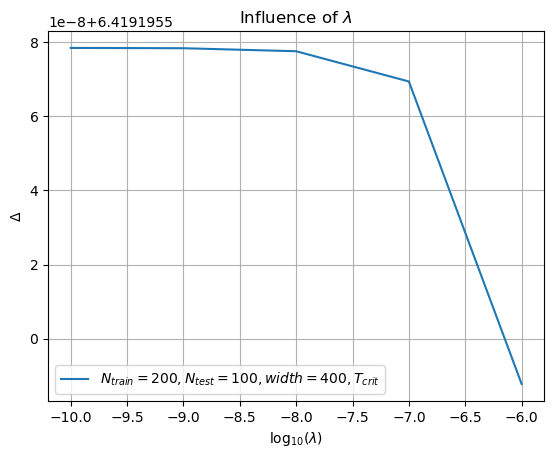

In [310]:
#Plot

plot(-1 .* collect(2:10),D_LAM2, label=L"N_{train}=1000, width=2000, T_{4}")


#Kosmetik
title(L"Influence of $\lambda$")
xlabel(L"\log_{10}(\lambda)") 
ylabel(L"\Delta")
grid()
legend()

#save plot with good enougt dpi
plt.savefig("Influence of lam T4",dpi=400)


**1 N_testing**

Alle Plots mit N_te=100 gemacht, spaart rechenleistung

Das ist noch ein  alter plot  der hier gezeigt wird, man müsste die zeilen neu ausführen

In [13]:
#Eifluss des anzal der testdaten:

T_n_range = collect(2:20) 
N_tr = 30
width = 100

#Berechnen
D_50t = [ Difference(N_tr,T_n,width,1111,50) for T_n in T_n_range ];
D_100t = [ Difference(N_tr,T_n,width,11111,100) for T_n in T_n_range ];
D_500t = [ Difference(N_tr,T_n,width,1111,500) for T_n in T_n_range ];

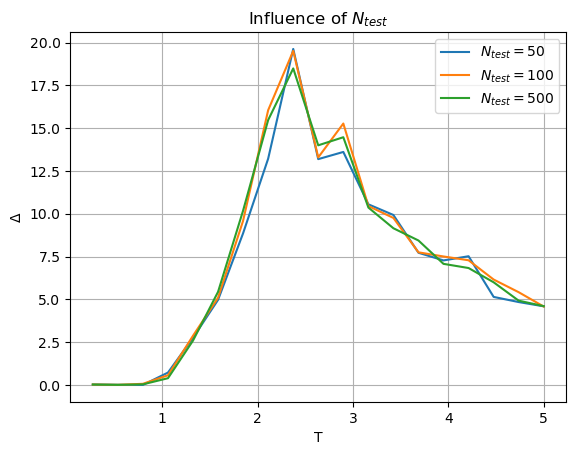

In [30]:
plot(T_range[2:20], D_50t, label=L"N_{test}=50")
plot(T_range[2:20], D_100t, label=L"N_{test}=100")
plot(T_range[2:20], D_500t, label=L"N_{test}=500")


#Kosmetik
title(L"Influence of $N_{test}$")
xlabel("T") 
ylabel(L"\Delta")
grid()
legend()

#save plot with good enougt dpi
plt.savefig("IMG/Influence of N_te",dpi=400)

**Große Unterschiede bei T_crit**

In [5]:
T_range

20-element Vector{Float64}:
 0.01
 0.273
 0.535
 0.798
 1.061
 1.323
 1.586
 1.848
 2.111
 2.374
 2.636
 2.899
 3.162
 3.424
 3.687
 3.949
 4.212
 4.475
 4.737
 5.0

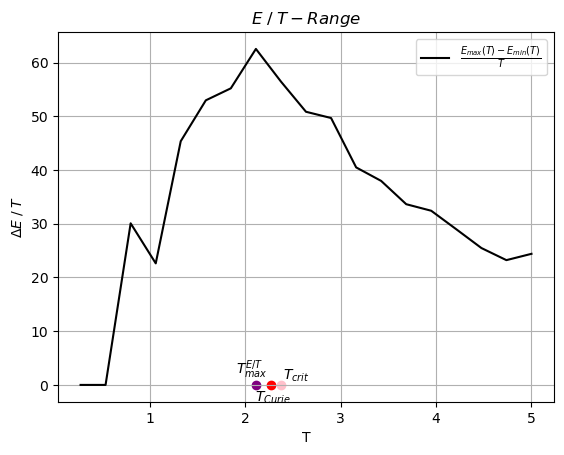

In [15]:
E_T=[maximum(y_ges[T_n])-minimum(y_ges[T_n]) for T_n in 2:20 ]


plot(T_range[2:end],E_T, label=L"\frac{E_{max}(T)-E_{min}(T)}{T}",color="black")
scatter([2.269],[0], color="red")
text(2.1, -3, L"T_{Curie}")

scatter([2.374],[0], color="pink")
text(2.4, 1, L"T_{crit}")

scatter([2.111],[0], color="purple")
text(1.9, 2, L"T_{max}^{E/T}")

#Kosmetik
title(L"E \; /\;T-Range")
xlabel("T") 
ylabel(L"\Delta E \; /\;T")
grid()
legend()

#save plot with good enougt dpi
# plt.savefig("IMG/DeltaE_T",dpi=400)

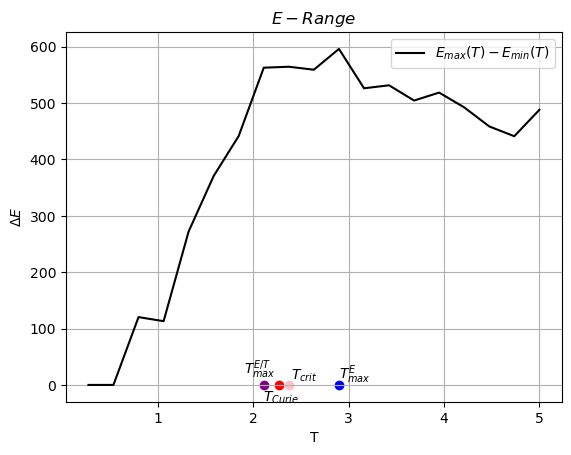

In [20]:
E=[(maximum(y_ges[T_n])-minimum(y_ges[T_n]))*T_n for T_n in 2:20 ]


plot(T_range[2:end],E, label=L"E_{max}(T)-E_{min}(T)", color="black")
scatter([2.269],[0], color="red")
text(2.1, -30, L"T_{Curie}")

scatter([2.374],[0], color="pink")
text(2.4, 10, L"T_{crit}")

scatter([2.899],[0], color="blue")
text(2.9, 10, L"T_{max}^E")

scatter([2.111],[0], color="purple")
text(1.9, 20, L"T_{max}^{E/T}")

#Kosmetik
title(L"E-Range")
xlabel("T") 
ylabel(L"\Delta E")
grid()
legend()

#save plot with good enougt dpi
plt.savefig("IMG/DeltaE",dpi=400)

**2 konvergenzbreite**

Das ist noch ein  alter plot  der hier gezeigt wird, man müsste die zeilen neu ausführen

In [ ]:
#---------konvergenzbreite und mindesttrainingsanzahl ---------------#

In [148]:
#ns=10

T_n = 10 # für T_crit (T_1 hier =0.01 in der bachlorarbiet dann T_1=0.27)


N_tr_range = [60, 100 , 150, 200]
width_range2 = Int64.(ceil.(range(10,5000, length = 5))) 

DIFF2 = []

for i in 1:length(N_tr_range)
push!(DIFF2, [ Difference(N_tr_range[i] ,T_n,w) for w in width_range2 ]) #N_te = 100
end


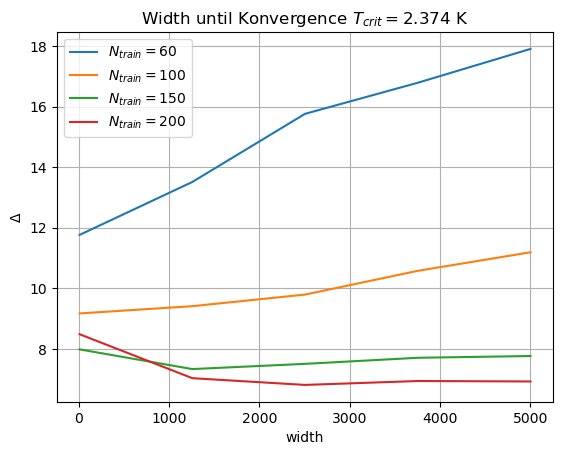

In [149]:
for i in 1:length(DIFF2)
plot(width_range2, DIFF2[i], label =L"N_{train} = %$(N_tr_range[i])")
end

#Kosmetik
title(L"Influence of m, $T_{crit}=%$(T_range[T_n])$")
xlabel("Width m") 
ylabel(L"\Delta")
grid()
legend()

#save plot with good enougt dpi
plt.savefig("Influence of m Tc",dpi=400)


In [ ]:
# auch mindest knvergen breite macht keinen sinn, wenn die vorehrsage bei N_tr=200 schlechter ist

In [ ]:
#Auch für Andere Temperaturen ab N_tr = 200 undwidth = 2000 ?

In [ ]:
N_te = 100
T_n_range = [6,14,18]


N_tr = 200
width_range = Int64.(ceil.(range(10,5000, length = 6))) 

DIFF = []

for i in 1:length(T_n_range)
push!(DIFF, [ Difference(N_tr ,T_n_range[i],w) for w in width_range ])
end


In [ ]:
plot(width_range, DIFF[1], label =L"T_5 = %$(T_range[T_n_range[1]])")
plot(width_range, DIFF[2], label =L"T_{13} = %$(T_range[T_n_range[2]])")
plot(width_range, DIFF[3], label =L"T_{17} = %$(T_range[T_n_range[3]])")

plot(width_range2, DIFF2[end], label =L"$T_{crit}=%$(T_range[T_n])$",color="red") #für T crit


#Kosmetik
title(L"Influence of m, $N_{train}=200$")
xlabel("Width m") 
ylabel(L"\Delta")
grid()
legend()

#save plot with good enougt dpi
plt.savefig("Influence of m Ntr",dpi=400)


Das ist noch ein  alter plot  der hier gezeigt wird

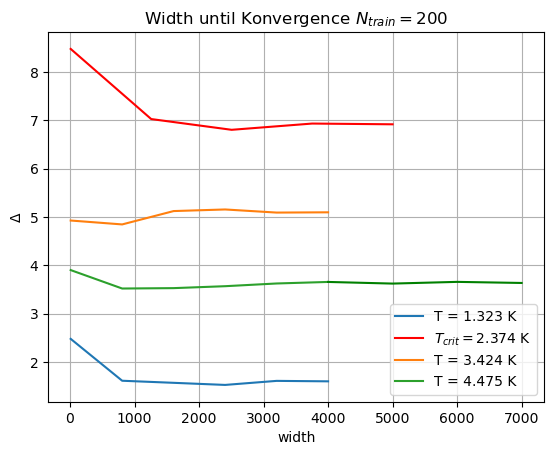

In [153]:
# for i in 1:length(DIFF)
# plot(width_range, DIFF[i], label ="T = $(T_range[T_n_range[i]]) K")
#     if i == 1
#         plot(width_range2, DIFF2[end], label =L"$T_{crit}=%$(T_range[T_n])$ K",color="red") #für T crit
#     end
# end
# plot(width_range3g, DIFF3[1],color="green") #geeen bis 7000


# #Kosmetik
# title(L"Width until Konvergence $N_{train}=200$")
# xlabel("width") 
# ylabel(L"\Delta")
# grid()
# legend()

# #save plot with good enougt dpi
# plt.savefig("IMG/Width until Konvergence N_tr 200",dpi=400)

In [16]:
# Daten Laden     (verwendete seeds= 1000,2000,3000,4000,5000)
N_tr_range3 = load_object("N_tr_range3 until Konvergece.jdl2");

D3_1 = load_object("N_tr until Konvergece Tcrit 1.jdl2");
D3_2 = load_object("N_tr until Konvergece Tcrit 2.jdl2");
D3_3 = load_object("N_tr until Konvergece Tcrit 3.jdl2");
D3_4=  load_object("N_tr until Konvergece Tcrit 4.jdl2");
D3_5 = load_object("N_tr until Konvergece Tcrit 5.jdl2");


# durchschnitt berechnen
D3 = (1/5)*(D3_1+D3_2+D3_3+D3_4+D3_5);

**4 Generierung und Formatierung der \Delta-Daten** (Daten im repository, der teil kann übersprungen werden)

(Unübersichtlich, da die daten einzelnd und auf verschiedenen rechenern, berechnet worden sind und im nachhinein dann zusammendgefasst wurden. Die Zusammengefassten Daten findet man im repository unter 'Alle Daten Trajektorien_all[T_index][1bis5 Trajektorien].jdl2', 'Alle Daten Trajektorien_avg[T_index].jdl2' und 'Alle Daten Trajektorien_err[T_index].jdl2').

mit w_konv=2000, N_min=200 bis N_tr_max=5000

In [13]:
width_konv = 2000
N_tr_range3 = Int64.(ceil.(range(200,5000, length=10)));

In [14]:
#Generierung der \Delta-Daten# 

# außer für T_n=10 und =20, weil habe ich schon oben "D3_1 und D3_1b"
# seed=T_n*100+(i-1)*10

In [ ]:
#Daten wurden auf einem unter anderem auf einem anderen rechener mit dem code generiert:
#Alle berechnungen lasssen sich mit dieser Schleife zusammenfassen:

# Temperaturen_n = [2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20]  #(für T_n=10 wurden alle 5 trajektorien schon einzelnd berechent, noch zu ergänzen, falls man sich die daten selbst erzeugen will)

# for T_n in Temperaturen_n
#     println("Temp_n: $(T_n)\n")
#     Trajektorien = []
#     for i in 2:5 #Für i=1 wurden die daten vorher schon einzelnd berechnet, „for i in 1:5“ schreiben, falls man sich die daten selbst erzeugen will
        
# println("$(i)  start: $(Dates.min(now()))")
# DHi = [ Difference(N_tr,T_n,width_konv,T_n*100+(i-1)*10) for N_tr in N_tr_range3 ]
#         push!(Trajektorien,DHi)
# println("$(i)  ende: $(Dates.min(now()))\n")
        
# save_object("Heatmap T_n=$(T_n) Trajektorien.jdl2", Trajektorien) #zwischnespeichern
# println("$(i) Gespeichert\n")
#     end
    
# println("-----------------------------------------------\n")
#     println("T_n=$(T_n) Komplett")
#     println("-----------------------------------------------\n")
# end


Generierte Daten Laden und zusammenfassen 
(Wenn man sich die daten selbst generiert hat muss man den code hier etwas anpassen)

In [59]:
#Alle Trajektorein laden:
DH_2 = load_object("Heatmap T_n=2.jdl2");
DH_3 = load_object("Heatmap T_n=3.jdl2");
DH_4 = load_object("Heatmap T_n=4.jdl2");
DH_5 = load_object("Heatmap T_n=5.jdl2");
DH_6 = load_object("Heatmap T_n=6.jdl2");
DH_7 = load_object("Heatmap T_n=7.jdl2");
DH_8 = load_object("Heatmap T_n=8.jdl2");
DH_9 = load_object("Heatmap T_n=9.jdl2");
DH_10 = load_object("N_tr until Konvergece Tcrit 1.jdl2");
DH_11 = load_object("Heatmap T_n=11.jdl2");
DH_12 = load_object("Heatmap T_n=12.jdl2");
DH_13= load_object("Heatmap T_n=13.jdl2");
DH_14 = load_object("Heatmap T_n=14.jdl2");
DH_15 = load_object("Heatmap T_n=15.jdl2");
DH_16 = load_object("Heatmap T_n=16.jdl2");
DH_17 = load_object("Heatmap T_n=17.jdl2");
DH_18 = load_object("Heatmap T_n=18.jdl2");
DH_19 = load_object("Heatmap T_n=19.jdl2");
DH_20 = load_object("N_tr until Konvergece T_n=20 1.jdl2");

In [60]:
#  Hier alle trajektorien Laden und mit den anderen kombinieren:
Trajektorien_all = []

DH_2T = load_object("Heatmap T_n=$(2) Trajektorien.jdl2");
push!(DH_2T,DH_2)
push!(Trajektorien_all,DH_2T)

DH_3T = load_object("Heatmap T_n=$(3) Trajektorien.jdl2");
push!(DH_3T,DH_3)
push!(Trajektorien_all,DH_3T)

DH_4T = load_object("Heatmap T_n=$(4) Trajektorien.jdl2");
push!(DH_4T,DH_4)
push!(Trajektorien_all,DH_4T)

DH_5T = load_object("Heatmap T_n=$(5) Trajektorien.jdl2");
push!(DH_5T,DH_5)
push!(Trajektorien_all,DH_5T)

DH_6T = load_object("Heatmap T_n=$(6) Trajektorien.jdl2");
push!(DH_6T,DH_6)
push!(Trajektorien_all,DH_6T)

DH_7T = load_object("Heatmap T_n=$(7) Trajektorien.jdl2");
push!(DH_7T,DH_7)
push!(Trajektorien_all,DH_7T)

DH_8T = load_object("Heatmap T_n=$(8) Trajektorien.jdl2");
push!(DH_8T,DH_8)
push!(Trajektorien_all,DH_8T)

DH_9T = load_object("Heatmap T_n=$(9) Trajektorien.jdl2");
push!(DH_9T,DH_9)
push!(Trajektorien_all,DH_9T)
##########
# hier muss andere code hin 10er hatte ich ja schon vorher abgeseicehrt
D3_1 = load_object("N_tr until Konvergece Tcrit 1.jdl2");
D3_2 = load_object("N_tr until Konvergece Tcrit 2.jdl2");
D3_3 = load_object("N_tr until Konvergece Tcrit 3.jdl2");
D3_4=  load_object("N_tr until Konvergece Tcrit 4.jdl2");
D3_5 = load_object("N_tr until Konvergece Tcrit 5.jdl2");

DH_10T = []
push!(DH_10T,D3_1)
push!(DH_10T,D3_2)
push!(DH_10T,D3_3)
push!(DH_10T,D3_4)
push!(DH_10T,D3_5)

push!(Trajektorien_all,DH_10T)
#####################
DH_11T = load_object("Heatmap T_n=$(11) Trajektorien.jdl2");
push!(DH_11T,DH_11)
push!(Trajektorien_all,DH_11T)

DH_12T = load_object("Heatmap T_n=$(12) Trajektorien.jdl2");
push!(DH_12T,DH_2)
push!(Trajektorien_all,DH_12T)

DH_13T = load_object("Heatmap T_n=$(13) Trajektorien.jdl2");
push!(DH_13T,DH_13)
push!(Trajektorien_all,DH_13T)

DH_14T = load_object("Heatmap T_n=$(14) Trajektorien.jdl2");
push!(DH_14T,DH_14)
push!(Trajektorien_all,DH_14T)

DH_15T = load_object("Heatmap T_n=$(15) Trajektorien.jdl2");
push!(DH_15T,DH_15)
push!(Trajektorien_all,DH_15T)

DH_16T = load_object("Heatmap T_n=$(16) Trajektorien.jdl2");
push!(DH_16T,DH_16)
push!(Trajektorien_all,DH_16T)

DH_17T = load_object("Heatmap T_n=$(17) Trajektorien.jdl2");
push!(DH_17T,DH_17)
push!(Trajektorien_all,DH_17T)

DH_18T = load_object("Heatmap T_n=$(18) Trajektorien.jdl2");
push!(DH_18T,DH_18)
push!(Trajektorien_all,DH_18T)

DH_19T = load_object("Heatmap T_n=$(19) Trajektorien.jdl2");
push!(DH_19T,DH_19)
push!(Trajektorien_all,DH_19T)

DH_20T = load_object("Heatmap T_n=$(20) Trajektorien.jdl2");
push!(DH_20T,DH_20)
push!(Trajektorien_all,DH_20T)


#Abspeichern Aller generierten Daten
save_object("Alle Daten Trajektorien_all[T_index][1bis5 Trajektorien].jdl2",Trajektorien_all)

In [19]:
# für alle den mittelwert berechen:

Trajektorien_avg = []
Trajektorien_err = []

for T_n_plus1 in 1:19
    n=length(Trajektorien_all[T_n_plus1])
AVG = (1/n) .*sum( Trajektorien_all[T_n_plus1] )
push!(Trajektorien_avg, AVG )
    
ERR = 1/sqrt((n)*(n-1))*sqrt.( sum(  [ (Trajektorien_all[T_n_plus1][i] .-AVG ) .^2   for i in 1:n] ))
push!(Trajektorien_err, ERR)
    
end
    
#Abspeichern Aller der mittelwerte
# save_object("Alle Daten Trajektorien_avg[T_index].jdl2",Trajektorien_avg)
save_object("Alle Daten Trajektorien_err[T_index].jdl2",Trajektorien_err)

In [83]:
# #Daten
# errorbar(N_tr_range3, # Original x data points, N values
#     Trajektorien_avg[10], # Original y data points, N values
#     yerr=Trajektorien_err[10],
#     fmt = ".",
#     ecolor="orange"
#     , label = "Daten",
#     color ="red") # Format



In [ ]:
#########################################################################

**-------------------Analyse-------------------**

In [ ]:
#Im latex dokument ist T_1 = 0,2.. und nicht 0,01

In [2]:
#Generierte Daten laden
# N_tr_range3 = load_object("N_tr_range3 until Konvergece.jdl2");
N_tr_range3 = Int64.(ceil.(range(200,5000, length=10)));
width_konv = 2000
T_range = round.(range(0.01,5, length=20),digits=3) # runden, damit plots schöner

Trajektorien_all=load_object("Alle Daten Trajektorien_all[T_index][1bis5 Trajektorien].jdl2");
Trajektorien_avg =load_object("Alle Daten Trajektorien_avg[T_index].jdl2");
# Trajektorien_err =load_object("Alle Daten Trajektorien_err[T_index].jdl2");

In [3]:
# umformatieren
Trajektorien_avg = reduce(hcat,Trajektorien_avg);

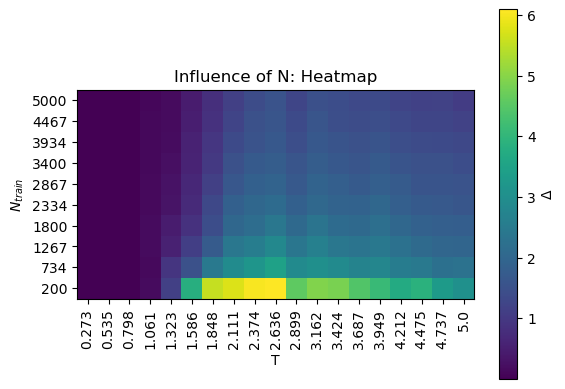

In [12]:
imshow(Trajektorien_avg,origin="lower")


#Kosmetik
title("Influence of N: Heatmap")
xlabel("T") 
xticks(ticks=collect(0:18),labels=T_range[2:end],rotation=90)
ylabel(L"N_{train}")
yticks(ticks=collect(0:9),labels=N_tr_range3)

colorbar(label=L"\Delta")

#save plot
# plt.savefig("IMG/Heatmap",dpi=400) 

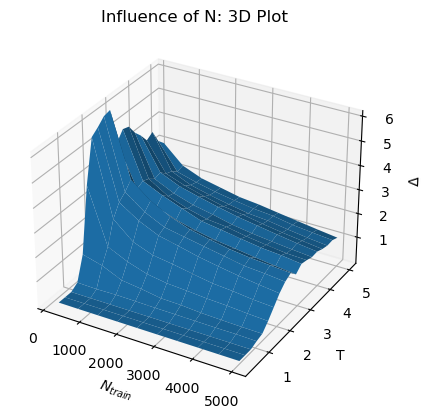

In [77]:
surf(N_tr_range3,T_range[2:end],Trajektorien_avg');

#Kosmetik
title("Influence of N: 3D Plot")
xlabel(L"$N_{train}$")
ylabel("T")
zlabel(L"\Delta")

#save plot
# plt.savefig("IMG/3D Plot",dpi=400) 

**Maximum**

In [4]:
x_max_index = []
y_maxima = []

for i in 1:10
    push!(y_maxima,findmax(Trajektorien_avg[i,:])[1])
    push!(x_max_index,findmax(Trajektorien_avg[i,:])[2])
end 

x_maxima = [T_range[2:end][x_max_index[i]] for i in 1:length(x_max_index)];
    

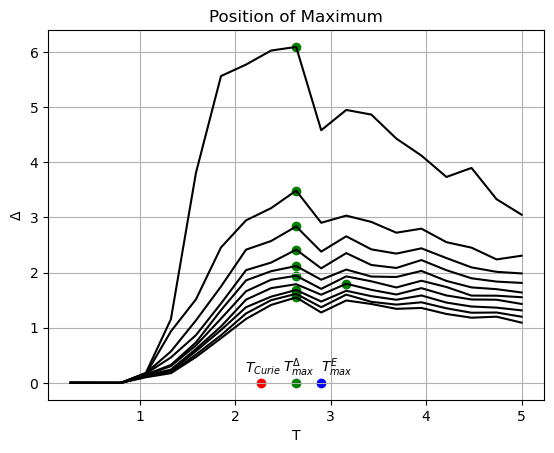

In [5]:
plot(T_range[2:end],Trajektorien_avg', color="black");
PyPlot.scatter(x_maxima,y_maxima,color="green");

scatter([2.269],[0], color="red")
text(2.1, 0.2, L"T_{Curie}")

scatter([2.636],[0], color="green")
text(2.5, 0.2, L"T_{max}^{\Delta}")

scatter([2.899],[0], color="blue")
text(2.9, 0.2, L"T_{max}^E")

#Kosmetik
title("Position of Maximum")
xlabel("T") 
ylabel(L"\Delta")
# legend()
grid(which="major", ls="solid")
grid(which="minor", ls="--")

#save plot
# plt.savefig("IMG/Position of Maximum",dpi=400) 

**Fitten**

In [169]:
#Fitten für die jeweiligen fälle T_0=Trange[1]

@. model_linear(x, p) = p[1]*x + p[2]    # mx+b

#jeweils mit den log/loglog daten fitten für T_7,  T_10,   T_15
T_fitdex = [6,10,19]

p0_pot_l_all = [[2.0,3.0],[2.0,3.0],[2.0,3.0]]
p0_exp_l_all = [[1/1000,3],[1/1000,3],[1/1000,3]]

pfit_pot_l_all = []
pfit_exp_l_all = []

#Fitten (bei exp die anfangswerte nicht berücksichtigen)
for i in 1:length(p0_pot_l_all)
    
    #Pot loglog linear
    pfit_pot_l=curve_fit(model_linear, log.(N_tr_range3), log.(Trajektorien_avg[T_fitdex[i]]), p0_pot_l_all[i]).param; # = e^b * x^m
    push!(pfit_pot_l_all,pfit_pot_l)
    
    #exp log linear
    pfit_exp_l=curve_fit(model_linear, N_tr_range3[3:end], log.(Trajektorien_avg[T_fitdex[i]][3:end]), p0_exp_l_all[i]).param; # m=exponentvorfaktor,b=ln(vorfaktor)
    push!(pfit_exp_l_all,pfit_exp_l)
    
end


#Modelle für den Plot
#Potenzfunktion
@. model_pot(x, p) = p[1]*x^(p[2])

#Exponentialfunktion
@. model_exp(x, p) = p[1]*exp(1)^(p[2]*x)

#Parameter aus den linearen fits umrechnen für die modelle für normale achsenskalierung

pfit_pot_all = []
pfit_exp_all = []

for i in 1:length(p0_pot_l_all)
    
    #Pot
    pfit_pot = [exp(pfit_pot_l_all[i][2]),pfit_pot_l_all[i][1]]
    push!(pfit_pot_all,pfit_pot)
    
    #exp
    pfit_exp = [exp(pfit_exp_l_all[i][2]),pfit_exp_l_all[i][1]];
    push!(pfit_exp_all,pfit_exp)

end

sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


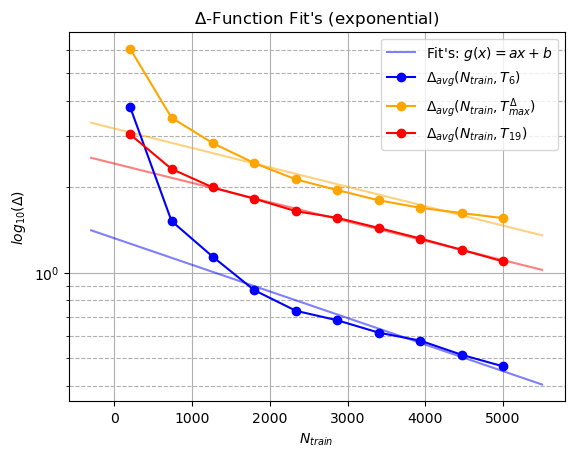

In [170]:
# semilogy plottet mit 10er log aber die funktion log() in julia ist zur bass e ,dann einfach log_10(x)=ln(x)/ln(10)

#semilog plot
Plot_bis = 5500

#Fit s
N_tr_fitrange3 = range(-300,Plot_bis,length=100)
semilogy(N_tr_fitrange3, [model_exp(x, pfit_exp_all[1]) for x in N_tr_fitrange3],color="blue",alpha=0.5, Label=L"Fit's: $g(x)=ax+b$")
semilogy(N_tr_fitrange3, [model_exp(x, pfit_exp_all[2]) for x in N_tr_fitrange3],color="orange",alpha=0.5)
semilogy(N_tr_fitrange3, [model_exp(x, pfit_exp_all[3]) for x in N_tr_fitrange3],color="red",alpha=0.5)

#Daten
semilogy(N_tr_range3,Trajektorien_avg[T_fitdex[1]],alpha=1,"-o",label=L"\Delta_{avg}(N_{train}, T_{6})",color="blue")
semilogy(N_tr_range3,Trajektorien_avg[T_fitdex[2]],alpha=1,"-o",label=L"\Delta_{avg}(N_{train}, T_{max}^{\Delta})",color="orange")
semilogy(N_tr_range3,Trajektorien_avg[T_fitdex[3]],alpha=1,"-o",label=L"\Delta_{avg}(N_{train}, T_{19})",color="red")



#trajektorien
# semilogy(N_tr_range3,Trajektorien_all[T_fitdex[2]][1],alpha=0.3,color="grey",label=L"ANN's")
# semilogy(N_tr_range3,Trajektorien_all[T_fitdex[2]][2],alpha=0.3,color="grey")
# semilogy(N_tr_range3,Trajektorien_all[T_fitdex[2]][3],alpha=0.3,color="grey")
# semilogy(N_tr_range3,Trajektorien_all[T_fitdex[2]][4],alpha=0.3,color="grey")
# semilogy(N_tr_range3,Trajektorien_all[T_fitdex[2]][5],alpha=0.3,color="grey")

#Kosmetik
title(L"$\Delta$-Function Fit's (exponential)")
xlabel(L"N_{train}") 
ylabel(L"log_{10}(\Delta)")
legend()
grid(which="major", ls="solid")
grid(which="minor", ls="--")

#save plot
# plt.savefig("IMG/Delta Fits exp",dpi=400)

# errorbar(N_tr_range3, # Original x data points, N values
#     Trajektorien_avg[T_fitdex[2]], # Original y data points, N values
#     yerr=log.(Trajektorien_err[T_fitdex[2]])./log(10),
#     fmt = ".",
#     ecolor="blue"
#     , label = "Daten",
#     color ="green") # Format

sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


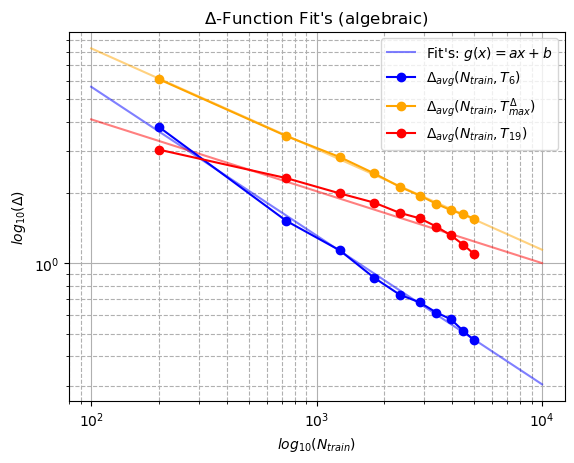

In [172]:
#doppelt logarithmisch
Plot_bis=4

#Fit
N_tr_fitrange3 = 10 .^(range(2,Plot_bis,length=100))
loglog(N_tr_fitrange3, [model_pot(x, pfit_pot_all[1]) for x in N_tr_fitrange3],color="blue",alpha=0.5, Label=L"Fit's: $g(x)=ax+b$")
loglog(N_tr_fitrange3, [model_pot(x, pfit_pot_all[2]) for x in N_tr_fitrange3],color="orange",alpha=0.5)
loglog(N_tr_fitrange3, [model_pot(x, pfit_pot_all[3]) for x in N_tr_fitrange3],color="red",alpha=0.5)


#Daten
loglog(N_tr_range3,Trajektorien_avg[T_fitdex[1]],"-o",alpha=1,label=L"\Delta_{avg}(N_{train}, T_{6})",color="blue")
loglog(N_tr_range3,Trajektorien_avg[T_fitdex[2]],"-o",alpha=1,label=L"\Delta_{avg}(N_{train}, T_{max}^{\Delta})",color="orange")
loglog(N_tr_range3,Trajektorien_avg[T_fitdex[3]],"-o",alpha=1,label=label=L"\Delta_{avg}(N_{train}, T_{19})",color="red")

#trajektorien
# loglog(N_tr_range3,D3_1,alpha=0.3,color="grey",label=L"ANN's")
# loglog(N_tr_range3,D3_2,alpha=0.3,color="grey")
# loglog(N_tr_range3,D3_3,alpha=0.3,color="grey")
# loglog(N_tr_range3,D3_4,alpha=0.3,color="grey")
# loglog(N_tr_range3,D3_5,alpha=0.3,color="grey")

#Kosmetik
title(L"$\Delta$-Function Fit's (algebraic)")
xlabel(L"log_{10}(N_{train})") 
ylabel(L"log_{10}(\Delta)")
legend()
grid(which="major", ls="solid") #oder which="both"wenn kein unterschied
grid(which="minor", ls="--")

#save plot
# plt.savefig("IMG/Delta Fits alg",dpi=400)

sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
sys:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


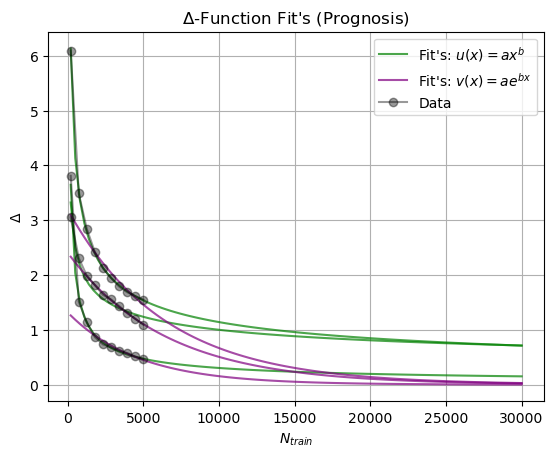

In [184]:
#Normaler plot nur mit den Fits

Plot_bis = 30000
N_tr_fitrange3 = range(200,Plot_bis,length=100)

#Fit pot
plot(N_tr_fitrange3, [model_pot(x, pfit_pot_all[1]) for x in N_tr_fitrange3],color="green",alpha=0.7, Label=L"Fit's: $u(x)=ax^{b}$")
plot(N_tr_fitrange3, [model_pot(x, pfit_pot_all[2]) for x in N_tr_fitrange3],color="green",alpha=0.7)
plot(N_tr_fitrange3, [model_pot(x, pfit_pot_all[3]) for x in N_tr_fitrange3],color="green",alpha=0.7)

#Fit s
plot(N_tr_fitrange3, [model_exp(x, pfit_exp_all[1]) for x in N_tr_fitrange3],color="purple",alpha=0.7, Label=L"Fit's: $v(x)=ae^{bx}$")
plot(N_tr_fitrange3, [model_exp(x, pfit_exp_all[2]) for x in N_tr_fitrange3],color="purple",alpha=0.7)
plot(N_tr_fitrange3, [model_exp(x, pfit_exp_all[3]) for x in N_tr_fitrange3],color="purple",alpha=0.7)



#Daten
plot(N_tr_range3,Trajektorien_avg[T_fitdex[1]],"-o",label="Data",color="black",alpha=0.4)
plot(N_tr_range3,Trajektorien_avg[T_fitdex[2]],"-o",color="black",alpha=0.4)
plot(N_tr_range3,Trajektorien_avg[T_fitdex[3]],"-o",color="black",alpha=0.4)


#Kosmetik
title(L"$\Delta$-Function Fit's (Prognosis)")
xlabel(L"N_{train}") 
ylabel(L"\Delta")
legend()
grid(which="major", ls="solid") #oder which="both"wenn kein unterschied
grid(which="minor", ls="--")

#save plot
# plt.savefig("IMG/Delta Fits prog",dpi=400)

**Spekulation**

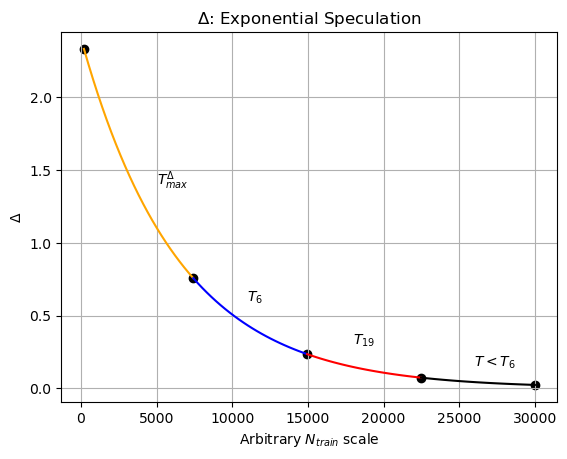

In [183]:
#plotten wie ich denke wir da sehen im überblick

N_tr_fitrange3 = range(200,Plot_bis,length=100)
plot(N_tr_fitrange3[1:25], [model_exp(x, pfit_exp_all[3]) for x in N_tr_fitrange3[1:25]],color="orange")
plot(N_tr_fitrange3[25:50], [model_exp(x, pfit_exp_all[3]) for x in N_tr_fitrange3[25:50]],color="blue")
plot(N_tr_fitrange3[50:75], [model_exp(x, pfit_exp_all[3]) for x in N_tr_fitrange3[50:75]],color="red")
plot(N_tr_fitrange3[75:100], [model_exp(x, pfit_exp_all[3]) for x in N_tr_fitrange3[75:end]],color="black")

scatter([N_tr_fitrange3[1],N_tr_fitrange3[25],N_tr_fitrange3[50],N_tr_fitrange3[75],N_tr_fitrange3[100]], [model_exp(x, pfit_exp_all[3]) for x in [N_tr_fitrange3[1],N_tr_fitrange3[25],N_tr_fitrange3[50],N_tr_fitrange3[75],N_tr_fitrange3[100]]],color="black")



#Kosmetik
title(L"$\Delta$: Exponential Speculation")
xlabel(L"Arbitrary $N_{train}$ scale") 
ylabel(L"\Delta")
# legend()
grid(which="major", ls="solid") #oder which="both"wenn kein unterschied
grid(which="minor", ls="--")

text(5000, 1.4, L"T_{max}^{\Delta}")
text(11000, 0.6, L"T_{6}")
text(18000, 0.3, L"T_{19}")
text(26000, 0.15, L"T<T_{6}")

#save plot
# plt.savefig("IMG/Delta speculation",dpi=400)

#1 2 4 3 farben ändern.
#Sind die temperaturen da wo ie sein sollen oder issehen wir einen adneren teil von der funktion bei zb t7

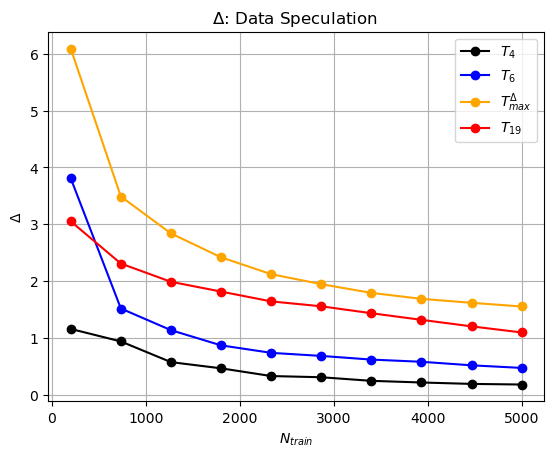

In [185]:
#Daten
plot(N_tr_range3,Trajektorien_avg[5],"-o",label=L"T_{4}",color="black")
plot(N_tr_range3,Trajektorien_avg[T_fitdex[1]],"-o",label=L"T_{6}",color="blue")
plot(N_tr_range3,Trajektorien_avg[T_fitdex[2]],"-o",label=L"T_{max}^{\Delta}",color="orange")
plot(N_tr_range3,Trajektorien_avg[T_fitdex[3]],"-o",label=L"T_{19}",color="red")

#Kosmetik
title(L"$\Delta$: Data Speculation ")
xlabel(L"N_{train}") 
ylabel(L"\Delta")
legend()
grid(which="major", ls="solid") #oder which="both"wenn kein unterschied
grid(which="minor", ls="--")

#save plot
# plt.savefig("IMG/Delta Data speculation",dpi=400)

Coding artefakte

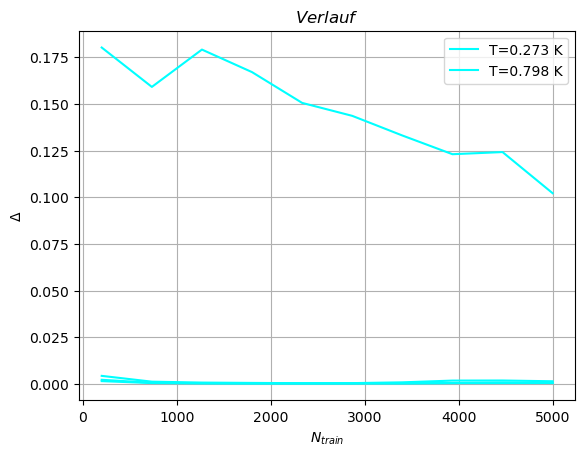

In [11]:
for i in 1:4
    
    if i < 6 #für Farben
        
    if mod(i,2) == 1 #jede zweite temperatur im label
    plot(N_tr_range3,Trajektorien_avg[:,i], label="T=$(T_range[i+1]) K",color="cyan")
    else
     plot(N_tr_range3,Trajektorien_avg[:,i],color="cyan") 
    end
        
    elseif  13 >= i >= 6
        
    if mod(i,2) == 1 #jede zweite temperatur im label
    plot(N_tr_range3,Trajektorien_avg[:,i], label="T=$(T_range[i+1]) K",color="orange")
    else
     plot(N_tr_range3,Trajektorien_avg[:,i],color="orange") 
    end   
        
    elseif   i >= 14
        
    if mod(i,2) == 1 #jede zweite temperatur im label
    plot(N_tr_range3,Trajektorien_avg[:,i], label="T=$(T_range[i+1]) K",color="red")
    else
     plot(N_tr_range3,Trajektorien_avg[:,i],color="red") 
    end     
            
        
    end
    
end

#Kosmetik
title(L"Verlauf")
xlabel(L"N_{train}") 
ylabel(L"\Delta")
legend()
grid(which="major", ls="solid")
grid(which="minor", ls="--")

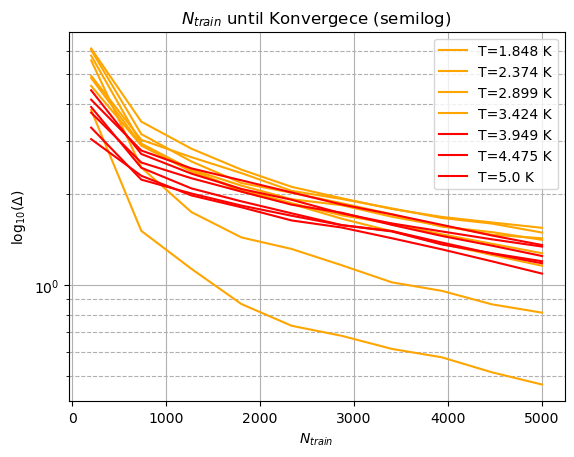

In [78]:
#semilog

for i in 6:(19)
    
    if i < 6 #für Farben
        
    if mod(i,2) == 1 #jede zweite temperatur im label
    semilogy(N_tr_range3,Trajektorien_avg[:,i], label="T=$(T_range[i+1]) K",color="cyan")
    else
     semilogy(N_tr_range3,Trajektorien_avg[:,i],color="cyan") 
    end
        
    elseif  13 >= i >= 6
        
    if mod(i,2) == 1 #jede zweite temperatur im label
    semilogy(N_tr_range3,Trajektorien_avg[:,i], label="T=$(T_range[i+1]) K",color="orange")
    else
     semilogy(N_tr_range3,Trajektorien_avg[:,i],color="orange") 
    end   
        
    elseif   i >= 14
        
    if mod(i,2) == 1 #jede zweite temperatur im label
    semilogy(N_tr_range3,Trajektorien_avg[:,i], label="T=$(T_range[i+1]) K",color="red")
    else
     semilogy(N_tr_range3,Trajektorien_avg[:,i],color="red") 
    end     
            
        
    end
    
end

#Kosmetik
title(L"$N_{train}$ until Konvergece (semilog)")
xlabel(L"N_{train}") 
ylabel(L"\log_{10}(\Delta)")
legend()
grid(which="major", ls="solid")
grid(which="minor", ls="--")

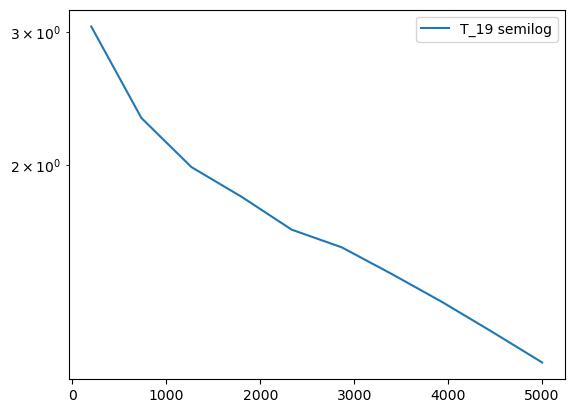

PyObject <matplotlib.legend.Legend object at 0x00000000A29F76A0>

In [89]:
semilogy(N_tr_range3,Trajektorien_avg[:,19],label="T_19 semilog")
legend()

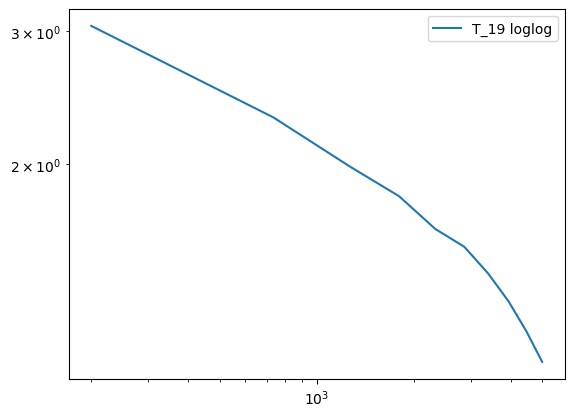

PyObject <matplotlib.legend.Legend object at 0x00000000AF23D1F0>

In [88]:
loglog(N_tr_range3,Trajektorien_avg[:,19],label="T_19 loglog")
legend()

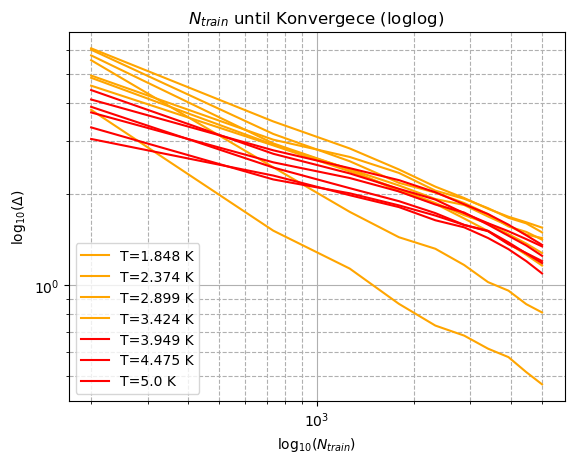

In [79]:
# loglog

for i in 6:(19)
    
    if i < 6 #für Farben
        
    if mod(i,2) == 1 #jede zweite temperatur im label
    loglog(N_tr_range3,Trajektorien_avg[:,i], label="T=$(T_range[i+1]) K",color="cyan")
    else
     loglog(N_tr_range3,Trajektorien_avg[:,i],color="cyan") 
    end
        
    elseif  13 >= i >= 6
        
    if mod(i,2) == 1 #jede zweite temperatur im label
    loglog(N_tr_range3,Trajektorien_avg[:,i], label="T=$(T_range[i+1]) K",color="orange")
    else
     loglog(N_tr_range3,Trajektorien_avg[:,i],color="orange") 
    end   
        
    elseif   i >= 14
        
    if mod(i,2) == 1 #jede zweite temperatur im label
    loglog(N_tr_range3,Trajektorien_avg[:,i], label="T=$(T_range[i+1]) K",color="red")
    else
     loglog(N_tr_range3,Trajektorien_avg[:,i],color="red") 
    end     
            
        
    end
    
end


#Kosmetik
title(L"$N_{train}$ until Konvergece (loglog)")
xlabel(L"\log_{10}(N_{train})") 
ylabel(L"\log_{10}(\Delta)")
legend()
grid(which="major", ls="solid")
grid(which="minor", ls="--")